<a href="https://colab.research.google.com/github/FREDY129053/Final_theory_work/blob/main/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
df = pd.read_csv('/content/ibm_data.csv')

In [ ]:
df['Date_point'] = pd.to_datetime(df['Date_point'])

In [ ]:
df.head(15)

,Date_point,Name,Open,High,Low,Close,Volume
0,2018-12-31,International Business Machines Corp,113.33,114.35,112.4201,113.67,4982755.0
1,2018-12-28,International Business Machines Corp,114.22,114.80,112.5000,113.03,5117533.0
2,2018-12-27,International Business Machines Corp,109.99,113.78,109.4700,113.78,6045590.0
3,2018-12-26,International Business Machines Corp,108.00,111.39,105.9400,111.39,6645794.0
4,2018-12-24,International Business Machines Corp,109.90,111.00,107.5000,107.57,3821376.0
5,2018-12-21,International Business Machines Corp,112.50,115.28,110.4400,110.94,10386453.0
6,2018-12-20,International Business Machines Corp,115.70,116.45,111.7000,113.02,8454350.0
7,2018-12-19,International Business Machines Corp,117.15,120.27,115.9700,116.43,6979823.0
8,2018-12-18,International Business Machines Corp,116.90,118.23,116.0200,116.65,6290186.0
9,2018-12-17,International Business Machines Corp,119.07,119.78,115.0700,116.10,7374476.0


## Генерация признаков

In [ ]:
!pip install pandas_ta

In [ ]:
import pandas_ta as ta

copy_df = df.copy()
# Признаки
copy_df['RSI']=ta.rsi(copy_df.Close, length=10)
copy_df['EMAF']=ta.ema(copy_df.Close, length=15)
copy_df['EMAM']=ta.ema(copy_df.Close, length=50)
copy_df['EMAS']=ta.ema(copy_df.Close, length=75)

# Разница между акцией следующей акции и сегодняшней
copy_df['Target'] = copy_df['Close'] - copy_df.Open
copy_df['Target'] = copy_df['Target'].shift(-1)

# Столбец: если 0, то акция упала в цене, если 1, то акция вырастает
copy_df['TargetClass'] = [1 if copy_df.Target[i] > 0 else 0 for i in range(len(copy_df))]

# Столбец показывающий стоимость акции следующего дня
copy_df['TargetNextClose'] = copy_df['Close'].shift(-1)

copy_df.dropna(inplace=True)
copy_df.reset_index(inplace = True)

dates = copy_df['Date_point']
print(dates.shape)
copy_df.drop(['Date_point', 'Name'], axis=1, inplace=True)
copy_df.drop('index', axis=1, inplace=True)

(4747,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(copy_df)
print(data_set_scaled)
print(data_set_scaled.shape)

[[0.57674361 0.57977387 0.58088465 ... 0.515      1.         0.56927767]
 [0.57064643 0.57336683 0.57408447 ... 0.52818182 1.         0.56877994]
 [0.56834443 0.56714824 0.56921829 ... 0.46272727 0.         0.56355379]
 ...
 [0.24755802 0.2370603  0.22453054 ... 0.43772727 0.         0.24450943]
 [0.25645492 0.24648241 0.24636596 ... 0.41772727 0.         0.24724694]
 [0.26192994 0.25194724 0.24755131 ... 0.42636364 0.         0.25931687]]
(4747, 12)


In [ ]:
X = []
backcandles = 15  # сколько дней будет учитываться для предсказывания цены
for j in range(9):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

X = np.moveaxis(X, [0], [2])
dates = np.array(dates[backcandles:])
X, yi = np.array(X), np.array(data_set_scaled[backcandles:,-1])
y = np.reshape(yi,(len(yi),1))

print(X.shape)
print(y.shape)

(4732, 15, 9)
(4732, 1)


## Модель

In [ ]:
# Разделение датасета
splitlimit = int(len(X)*0.8)
print(splitlimit)
dates = np.reshape(dates, (len(dates), 1))
print(dates.shape)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
dates_train, dates_test = dates[:splitlimit], dates[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(dates_test.shape)

3785
(4732, 1)
(3785, 15, 9)
(947, 15, 9)
(3785, 1)
(947, 1)
(947, 1)


In [ ]:
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers
from keras.layers import Input, Activation
from keras.models import Model

lstm_input = Input(shape=(backcandles, 9), name='lstm_input')
inputs = LSTM(250, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()

model.compile(optimizer=adam, loss='mse')
history = model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
228/228 [==============================] - 4s 6ms/step - loss: 0.0031 - val_loss: 2.0187e-04
Epoch 2/30
228/228 [==============================] - 1s 5ms/step - loss: 4.2631e-04 - val_loss: 1.3492e-04
Epoch 3/30
228/228 [==============================] - 1s 5ms/step - loss: 3.5083e-04 - val_loss: 7.6330e-05
Epoch 4/30
228/228 [==============================] - 1s 5ms/step - loss: 3.4310e-04 - val_loss: 8.2722e-05
Epoch 5/30
228/228 [==============================] - 1s 5ms/step - loss: 3.4678e-04 - val_loss: 2.0592e-04
Epoch 6/30
228/228 [==============================] - 1s 5ms/step - loss: 3.5683e-04 - val_loss: 1.9561e-04
Epoch 7/30
228/228 [==============================] - 1s 5ms/step - loss: 3.3738e-04 - val_loss: 8.3982e-05
Epoch 8/30
228/228 [==============================] - 1s 5ms/step - loss: 3.1615e-04 - val_loss: 7.4698e-05
Epoch 9/30
228/228 [==============================] - 1s 6ms/step - loss: 2.7485e-04 - val_loss: 9.2923e-05
Epoch 10/30
228/228 [===========

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

30/30 [==============================] - 0s 2ms/step
Mean Squared Error: 0.0003676824679281738
Mean Absolute Error: 0.014201935230363274


In [ ]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

30/30 [==============================] - 0s 2ms/step
[0.15856285] [0.16057985]
[0.1568538] [0.15939775]
[0.15670462] [0.15354943]
[0.15125594] [0.15417159]
[0.14974579] [0.16213526]
[0.15500836] [0.16300628]
[0.15373507] [0.16288185]
[0.15554498] [0.16107758]
[0.16042311] [0.16630374]
[0.1614916] [0.17090773]


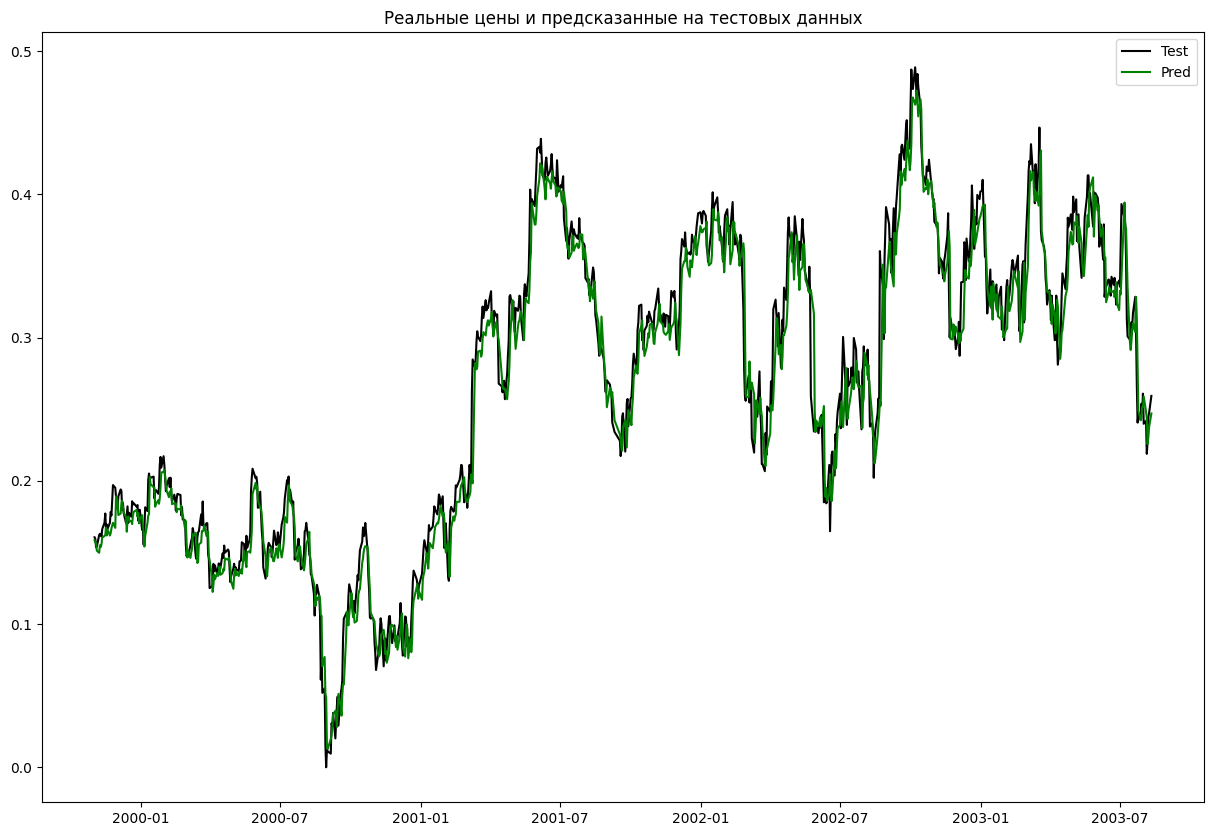

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.title('Реальные цены и предсказанные на тестовых данных')
plt.plot(dates_test[::-1], y_test, color = 'black', label = 'Test')
plt.plot(dates_test[::-1], y_pred, color = 'green', label = 'Pred')
# plt.plot(y_test, color = 'black', label = 'Test')
# plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

model.save('/content/drive/MyDrive/ANALITICA_MODEL_IBM.keras')

Mounted at /content/drive
